In [1]:
import scvelo as scv
import numpy as np
import pandas as pd

import scanpy as sc
import matplotlib.pyplot as plt 

In [2]:
adata = scv.datasets.pancreas()


In [3]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)


# Foreign HVG

In [4]:
hvg = np.loadtxt("./ZPSGenes.tsv",dtype=str)
hvg.shape

(1352,)

In [5]:
filtered = adata[:,hvg]

In [6]:
sc.pp.highly_variable_genes(adata,n_top_genes=4004)
adata.var['highly_variable']

index
Xkr4       False
Gm37381    False
Rp1        False
Rp1-1      False
Sox17      False
           ...  
Gm28672    False
Gm28670    False
Gm29504    False
Gm20837    False
Erdr1      False
Name: highly_variable, Length: 27998, dtype: bool

In [7]:
sc_calls = adata.var_names[adata.var['highly_variable']]
foreign_calls = adata.var_names[actual_mask]

NameError: name 'actual_mask' is not defined

In [ ]:
np.sum(actual_mask.astype(dtype=int))

In [ ]:
len(set(sc_calls).intersection(set(foreign_calls)))

# Vignette Analysis

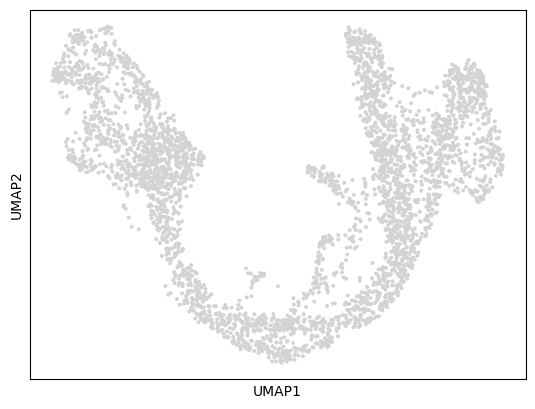

In [8]:
sc.pp.neighbors(filtered)
sc.tl.umap(filtered)
sc.pl.umap(filtered)

In [9]:
scv.pp.moments(filtered,n_neighbors=None,n_pcs=None)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [10]:
scv.tl.velocity(filtered)
scv.tl.velocity_graph(filtered)


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


# Velocity Graph 

In [11]:
pca_t0 = filtered.obsm['X_pca']

In [12]:
# We want this rather than the velocity graph in itself
tg = np.array(scv.utils.get_transition_matrix(filtered).todense())

In [13]:
def mean_velo(tg,data):
    wsum = np.matmul(tg,data) 
    norm_const = np.sum(tg,axis=1)
    wmean = (wsum.T / norm_const).T
    velo = wmean - data
    return velo
    # length = np.sqrt(np.sum(np.power(velo,2),axis=1))
    # unitized = (velo.T / length).T
    # return unitized

In [14]:
pca_v = mean_velo(tg,pca_t0)

pca_t1 = pca_t0 + (pca_v / 5)

np.savetxt("sc_velo_pca_t0.tsv",pca_t0)
np.savetxt("sc_velo_pca_t1.tsv",pca_t1)

# Foreign UMAP Train Transform 

In [15]:
import matplotlib.pyplot as plt 

In [16]:
from umap import UMAP
from sklearn.decomposition import PCA

In [17]:
umap_model = UMAP(n_neighbors=15,min_dist=0.5, spread=1.0, n_components=2, negative_sample_rate=5, random_state=0,metric='cosine')
u_t0 = umap_model.fit_transform(pca_t0)

In [18]:
u_t1 = umap_model.transform(pca_t1)

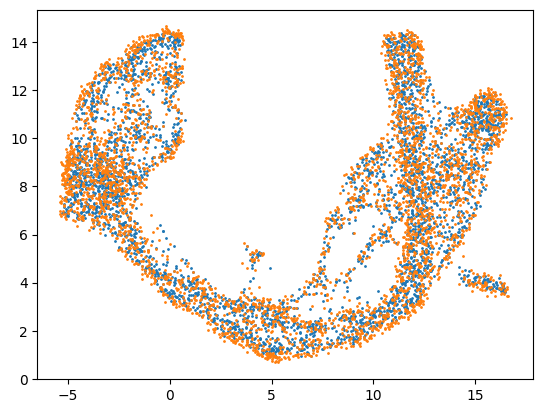

In [19]:
plt.figure()
plt.scatter(*u_t0.T,s=1)
plt.scatter(*u_t1.T,s=1)
plt.show()

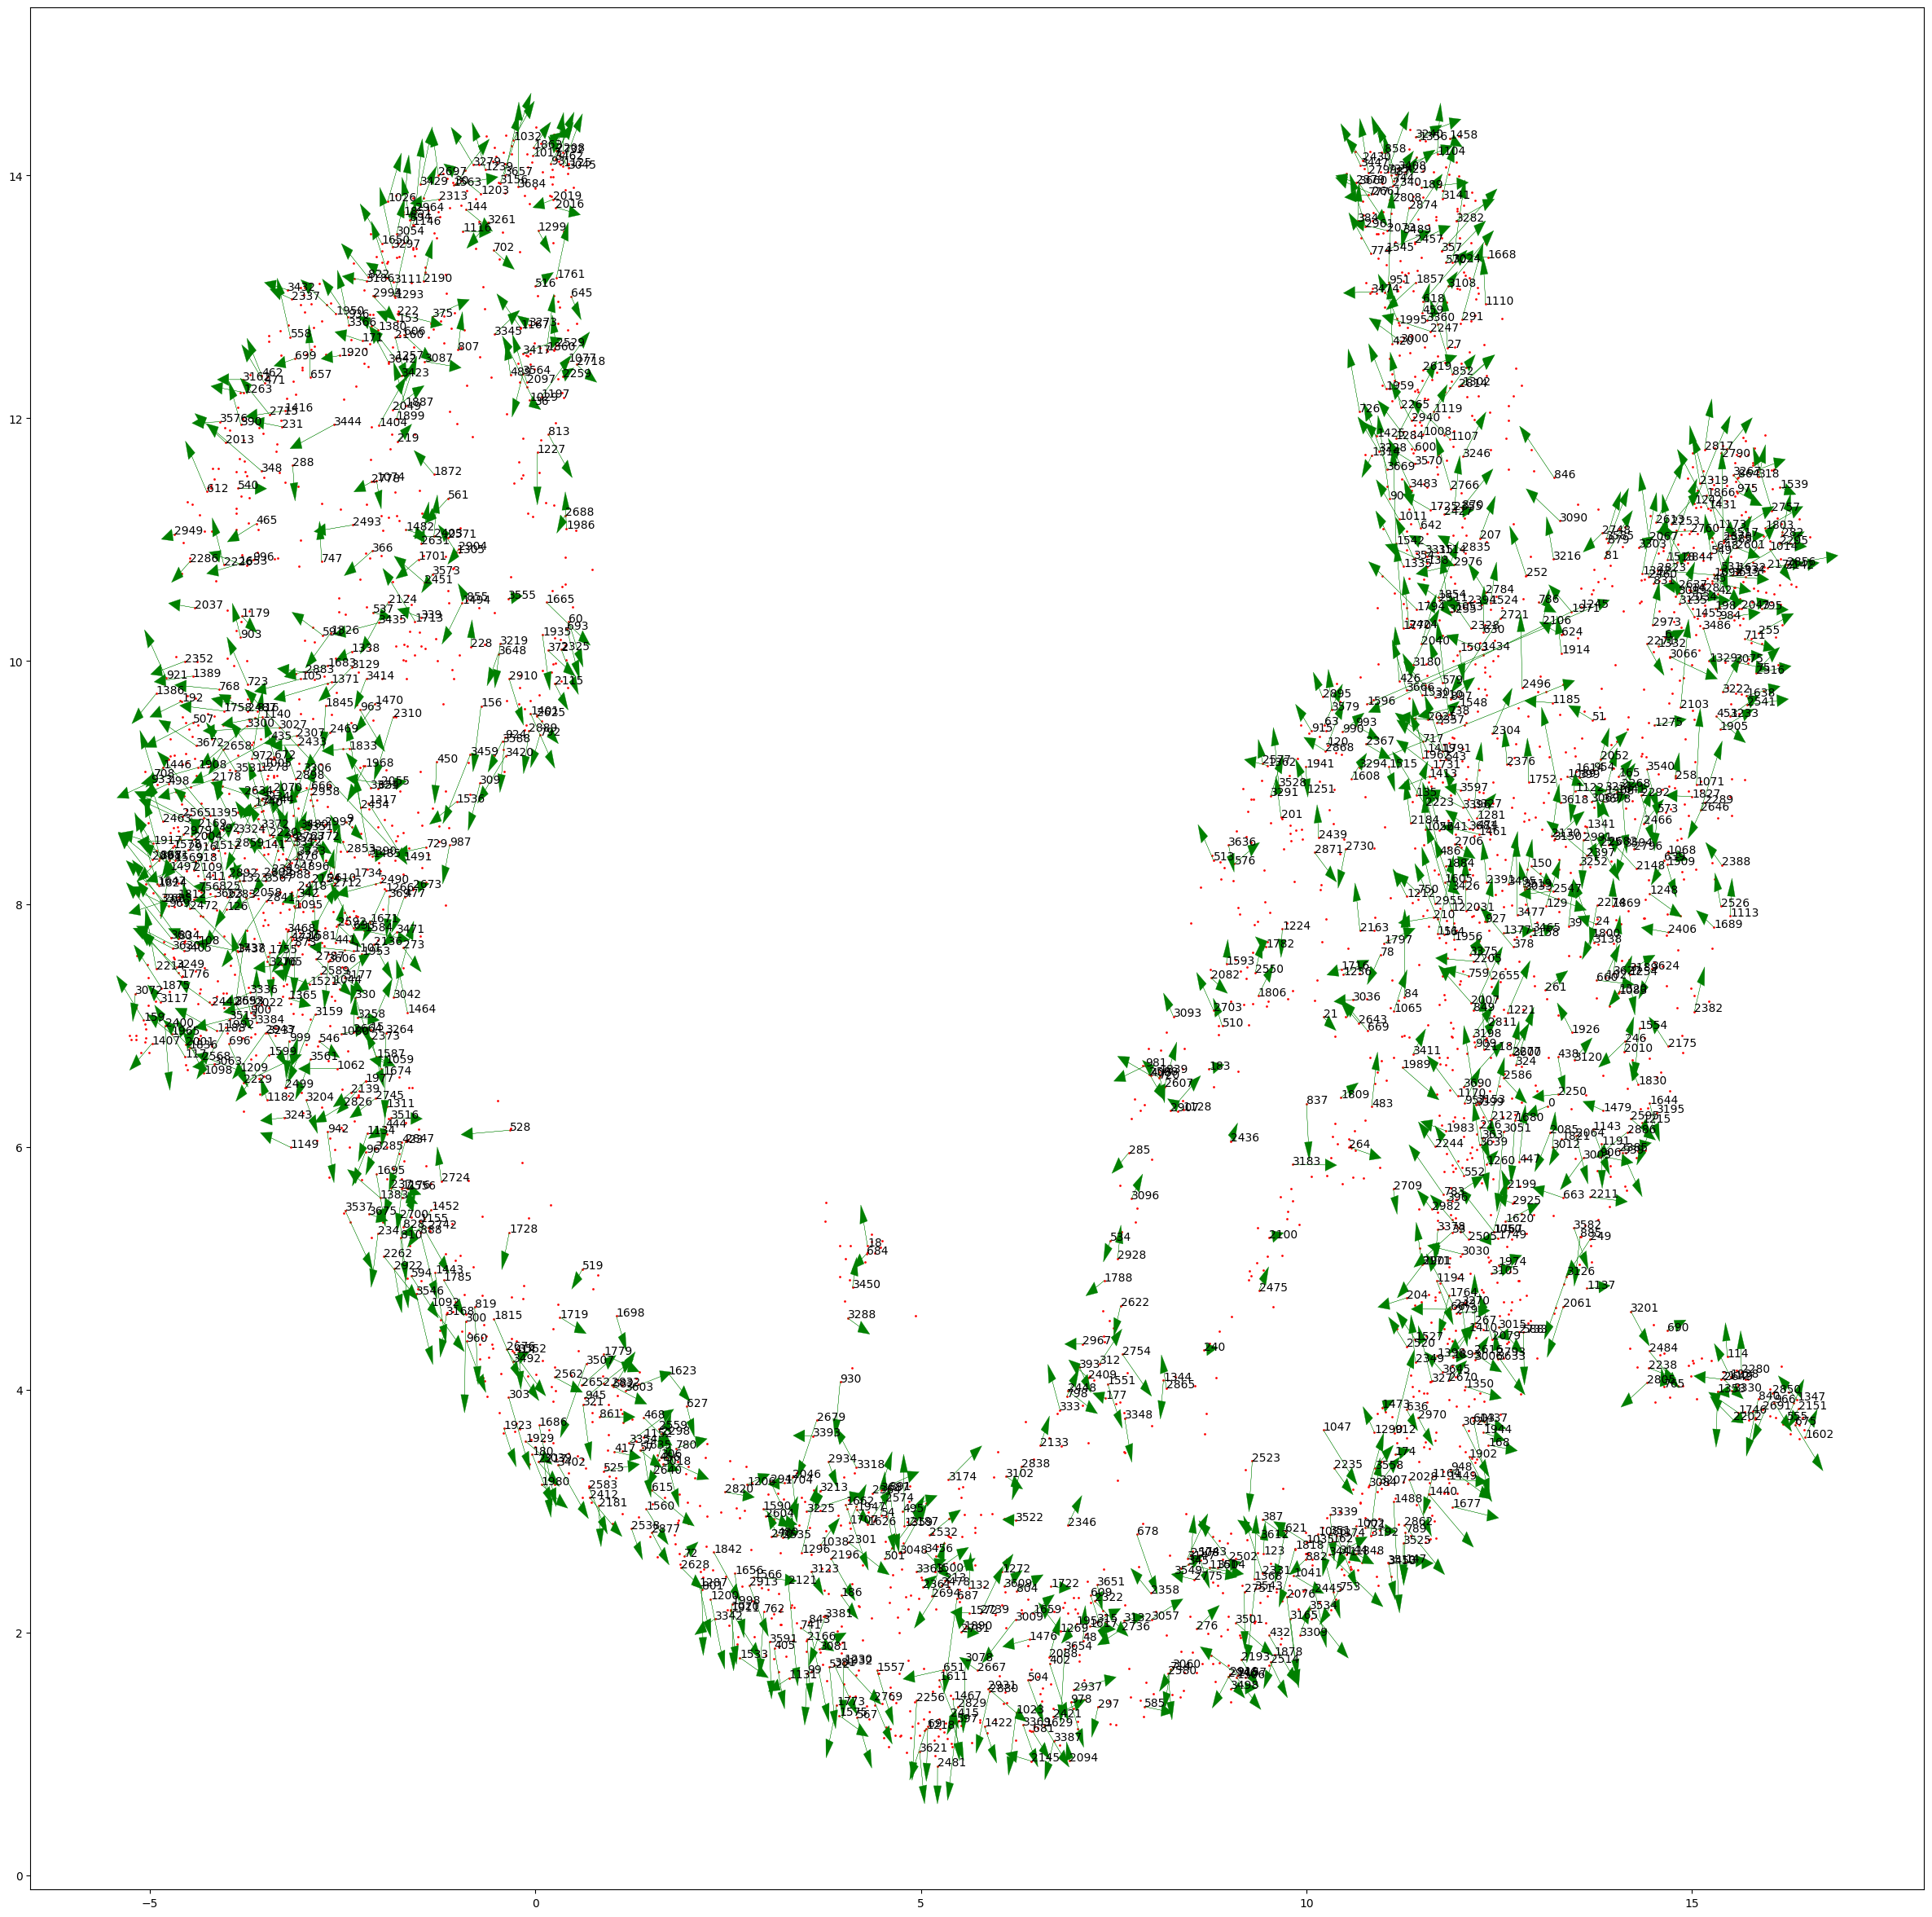

In [22]:
delta_graph(u_t0,u_t1-u_t0,arrow_frequency=3,figsize=(30,30))

# Foreign UMAP Joint

In [27]:
stacked = np.vstack([pca_t0,pca_t1])

umap_model = UMAP(n_neighbors=15,min_dist=0.5, spread=1.0, n_components=2, negative_sample_rate=5, random_state=0,metric='cosine')
u_tj = umap_model.fit_transform(stacked)

u_t0 = u_tj[:pca_t0.shape[0]]
u_t1 = u_tj[pca_t0.shape[0]:]

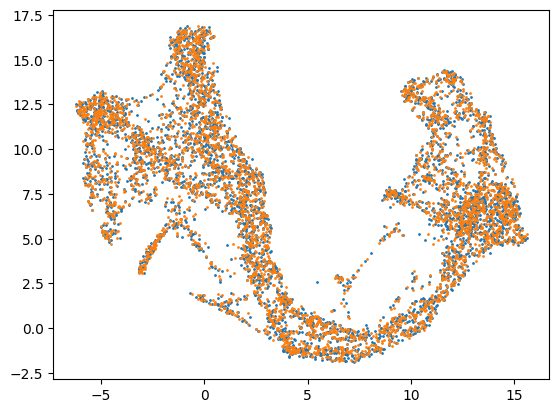

In [28]:
plt.figure()
plt.scatter(*u_t0.T,s=1)
plt.scatter(*u_t1.T,s=1)
plt.show()

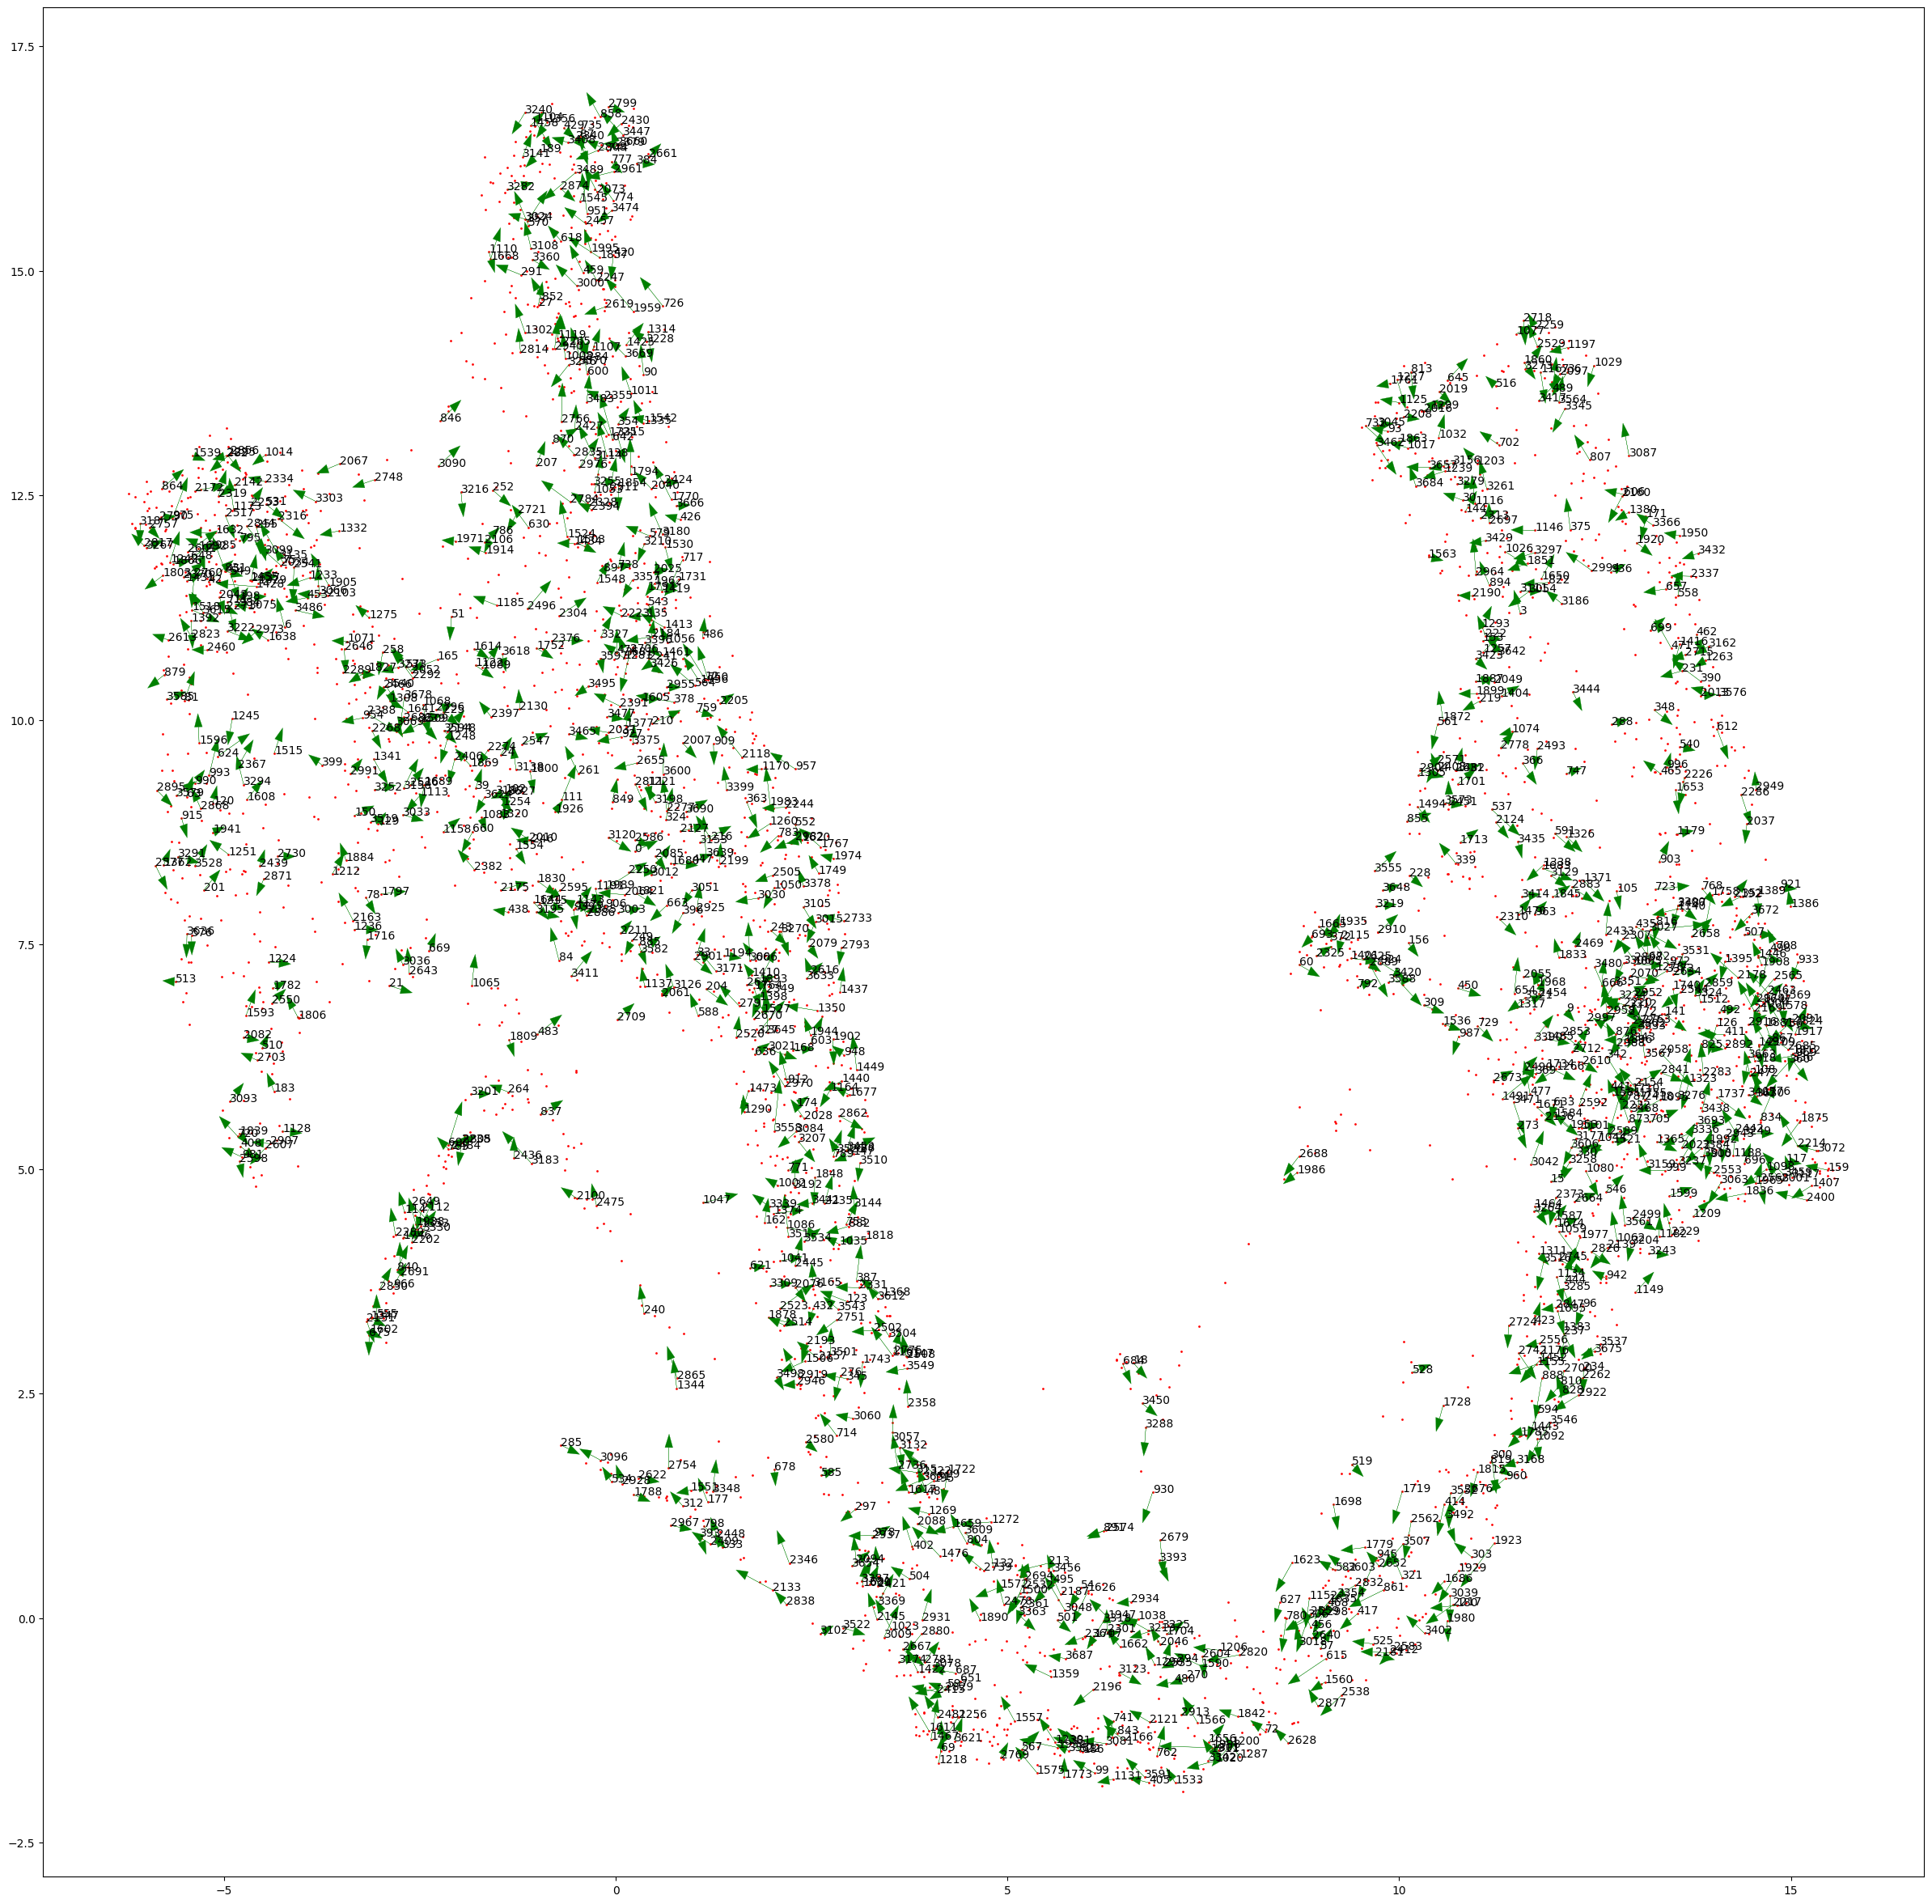

In [29]:
delta_graph(u_t0,u_t1-u_t0,arrow_frequency=3,figsize=(30,30))

In [ ]:
embedded = umap_model.transform(pca_transformed_trajectories)
embedded.shape

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(*u_t.T,s=1)
for i in range(0,embedded.shape[0],10):
    x,y = u_t[i]
    dx,dy = (u_t[i] - embedded[i]) / 2
    plt.arrow(x,y,dx,dy,color='red',head_width=.1,linewidth=.2)
    # plt.plot([u_t[i,0],embedded[i,0]],[u_t[i,1],embedded[i,1]],color='red')
plt.show()

In [21]:
def delta_graph(origin,delta,highlight=[0,1],arrow_frequency=30,figsize=(10,8)):

    plt.figure(figsize=figsize)
    plt.scatter(*origin.T,color='red',s=1)

    for i,((x,y),(dx,dy)) in enumerate(zip(origin,delta)):
        if i%arrow_frequency == 0:
            plt.text(*origin[i],s=f"{i}")
            plt.arrow(x,y,dx,dy,color='green',head_width=.1,linewidth=.2)

    plt.show()

# Let's compare smoothness in several situations 

In [67]:
from scipy.spatial.distance import pdist,squareform

def local_velocity_smoothness(velocities,knn):
    smoothness = []
    for neighborhood in knn:
        local_velocities = velocities[neighborhood]
        local_smoothness = np.mean(pdist(local_velocities,metric='cosine'))
        smoothness.append(local_smoothness)
    return smoothness

def extract_knn_from_adata(adata):

    samples = adata.shape[0]
    knn = []
    
    for i in range(samples):
        conn = np.array(adata.obsp['connectivities'][i].todense()).flatten()
        mask = conn > 0
        sort = np.argsort(conn[mask])
        indices = list(np.arange(samples)[mask][sort])
        knn.append(indices)
    
    clean = np.min([len(ragged) for ragged in knn])
    knn = [ragged[-clean:] for ragged in knn]
    return knn

knn = extract_knn_from_adata(filtered)

In [68]:
# raw(ish) velocity
local_velocity_smoothness(filtered.layers['velocity'],knn)

[0.42437992596353985,
 0.0608687119486613,
 0.4012624226258734,
 0.08898976696720647,
 0.27446695052091946,
 0.04321263245976153,
 0.13381654981298677,
 0.04325908760121702,
 0.03997027408717033,
 0.10709004687210785,
 0.08053417762214461,
 0.02610134885701676,
 0.4682767319977294,
 0.05781346752231706,
 0.06217912988329681,
 0.08272989006102853,
 0.04497409973225247,
 0.18212781229752048,
 0.17842894907345133,
 0.11796251425835602,
 0.06668824268986215,
 0.2617054926867937,
 0.2504344265935743,
 0.4432209750944065,
 0.15936447485025335,
 0.3070433915618948,
 0.10858489231676537,
 0.053269629026817054,
 0.049852013433788346,
 0.13597092124020096,
 0.02547834568693897,
 0.21144942791210847,
 0.5264960803280779,
 0.49086209938795244,
 0.25973833738432855,
 0.03305468135329967,
 0.06436181312401054,
 0.528339193834687,
 0.4857274857495785,
 0.2422425452602459,
 0.258727906502149,
 0.03637413897765812,
 0.19135790587459545,
 0.06082460227577976,
 0.15082515479371641,
 0.2238588282068107,
 

In [70]:
# PCA velocity
local_velocity_smoothness(pca_v,knn)

[0.8326893901378509,
 0.8453045071628502,
 0.7647789789534747,
 0.7061096273229157,
 0.817802540355132,
 0.8431418060605089,
 0.7535307017708109,
 0.9449662511321458,
 0.9113952833757272,
 0.7872015905446981,
 0.6501403180971642,
 0.8675498626341013,
 0.7937463561591345,
 0.890344279096887,
 0.8771223673971682,
 0.6930995274010018,
 0.7003148539706926,
 0.8382524490488517,
 0.4764832420850976,
 0.7997171765445695,
 0.7102660974917352,
 0.7808867207351324,
 0.7337608693857137,
 0.8262578701739739,
 0.7839813425300067,
 0.8255065952297758,
 0.7097449545530863,
 0.6876580480272827,
 0.9240701389251663,
 0.8588730821509649,
 0.8355966469673827,
 0.690624416250535,
 0.6396178071601909,
 0.811989618812927,
 0.7991639046860768,
 0.45678271670709797,
 0.8035488169131743,
 0.701111208695271,
 0.7449324113629622,
 0.7773401390303734,
 0.7363108611058479,
 0.7273347308993185,
 0.8626814584705962,
 0.7843758498480965,
 0.7360907161229002,
 0.8640581819395587,
 0.7130573767457832,
 0.84579787044192

In [61]:
# 

[0.8326893901378509,
 0.8453045071628502,
 0.7647789789534747,
 0.7061096273229157,
 0.817802540355132,
 0.8431418060605089,
 0.7535307017708109,
 0.9449662511321458,
 0.9113952833757272,
 0.7872015905446981,
 0.6501403180971642,
 0.8675498626341013,
 0.7937463561591345,
 0.890344279096887,
 0.8771223673971682,
 0.6930995274010018,
 0.7003148539706926,
 0.8382524490488517,
 0.4764832420850976,
 0.7997171765445695,
 0.7102660974917352,
 0.7808867207351324,
 0.7337608693857137,
 0.8262578701739739,
 0.7839813425300067,
 0.8255065952297758,
 0.7097449545530863,
 0.6876580480272827,
 0.9240701389251663,
 0.8588730821509649,
 0.8355966469673827,
 0.690624416250535,
 0.6396178071601909,
 0.811989618812927,
 0.7991639046860768,
 0.45678271670709797,
 0.8035488169131743,
 0.701111208695271,
 0.7449324113629622,
 0.7773401390303734,
 0.7363108611058479,
 0.7273347308993185,
 0.8626814584705962,
 0.7843758498480965,
 0.7360907161229002,
 0.8640581819395587,
 0.7130573767457832,
 0.84579787044192

In [65]:
filtered

AnnData object with n_obs × n_vars = 3696 × 1352
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'n_counts', 'velocity_self_transition'
    var: 'highly_variable_genes', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'log1p', 'umap', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

# Predicted Foreign Umap

In [ ]:
t_1 = np.loadtxt("./trajectories_t1.tsv",dtype=float).T
t_2 = np.loadtxt("./trajectories_t2.tsv",dtype=float).T
t_3 = np.loadtxt("./trajectories_t3.tsv",dtype=float).T
t_4 = np.loadtxt("./trajectories_t4.tsv",dtype=float).T
t_5 = np.loadtxt("./trajectories_t5.tsv",dtype=float).T
t_6 = np.loadtxt("./trajectories_t6.tsv",dtype=float).T


In [ ]:
def arrow_deltas(t1,t2):
    x,y = t1
    dx,dy = t2 - t1
    return (x,y,dx,dy)

def trajectory_series(trajectories,frequency=5):
    plt.figure(figsize=(30,30))
    plt.scatter(*trajectories[0].T,s=3)
    for t1,t2 in zip(trajectories[:-1],trajectories[1:]):
        for i in range(0,t1.shape[0],frequency): 
            plt.arrow(*arrow_deltas(t1[i],t2[i]),color='green',head_width=.05,linewidth=.2)
    plt.show()    

trajectory_series([u_t + 5,t_1,t_2,t_3,t_4,t_5,t_6])
    
# plt.figure(figsize=(30,30))
# plt.scatter(*u_t.T + 5,s=1)
# for i in range(0,trajectories_1.shape[0],30): 
#     plt.arrow(*arrow_deltas(u_t[i] + 5,trajectories_1[i]),color='red',head_width=.1,linewidth=.2)
#     plt.arrow(*arrow_deltas(trajectories_1[i],trajectories_2[i]),color='green',head_width=.1,linewidth=.2)
#     plt.arrow(*arrow_deltas(trajectories_2[i],trajectories_3[i]),color='blue',head_width=.1,linewidth=.2)
# plt.show()

In [ ]:
np.max(t_5,axis=0)

In [ ]:
# torubleshooting offsets

# some trajectory starts at ~ 4,10.5
# First let's index it, it should be easy to find 

t1


# Joint Embedding?

In [ ]:
t1 = np.array(filtered.X.copy().todense())

# # Is this in log space?
v = np.array(filtered.layers['velocity'])
v = np.log1p(np.abs(v)) * np.sign(v)

t2 = t1+(v/5)

# clip negatives

t2[t2 < 0] = 0

In [ ]:
from umap import UMAP
from sklearn.decomposition import PCA

def arrow_deltas(time1,time2,damping=1):
    x,y = time1
    dx,dy = time2 - time1
    return (x,y,dx*damping,dy*damping)
    
def simple_sequence(time1,time2,highlight=[0,1],arrow_frequency=30):
    pca_model = PCA(n_components=50)
    pca_t1 = pca_model.fit_transform(time1)
    pca_t2 = pca_model.transform(time2)
    
    umap_model = UMAP(n_neighbors=15,min_dist=0.5, spread=1.0, n_components=2, negative_sample_rate=5, random_state=0,metric='cosine')
    u_t1 = umap_model.fit_transform(pca_t1)
    u_t2 = umap_model.transform(pca_t2)

    plt.figure(figsize=(10,8))
    plt.scatter(*u_t1.T,color='red',s=1)
    # plt.show()
    # plt.figure(figsize=(10,8))
    plt.scatter(*u_t2.T,color='blue',s=1)
    plt.show()

    # plt.figure(figsize=(10,8))
    # plt.scatter(*u_t1.T,s=1)
    # for i in highlight:
    #     plt.text(*u_t1[i],s=f"{i}")
    #     plt.text(*u_t2[i],s=f"{i}'")
    #     plt.arrow(*arrow_deltas(u_t1[i],u_t2[i]),color='red',head_width=.1,linewidth=.2)
    # for i in range(0,u_t1.shape[0],arrow_frequency): 
    #     plt.arrow(*arrow_deltas(u_t1[i],u_t2[i]),color='green',head_width=.1,linewidth=.2)
    # plt.show()

    return u_t1
    
    # plt.figure(figsize=(10,8))
    # plt.scatter(*pca_t1[:,:2].T,s=1)
    # for i in highlight:
    #     plt.text(*pca_t1[i,:2],s=f"{i}")
    # for i in range(0,pca_t1[:,:2].shape[0],arrow_frequency): 
    #     plt.arrow(*arrow_deltas(pca_t1[i,:2],pca_t2[i,:2],damping=1),color='green',head_width=.1,linewidth=.2)
    # plt.show()